In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.util import montage

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from dataset import NibabelDataset

from dynamic_network_architectures.architectures.unet import PlainConvUNet, ResidualEncoderUNet

from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform
from batchgenerators.transforms.spatial_transforms import SpatialTransform
from batchgenerators.transforms.resample_transforms import SimulateLowResolutionTransform
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, ContrastAugmentationTransform, GammaTransform
from batchgenerators.transforms.utility_transforms import RenameTransform, NumpyToTensor

In [2]:
def numpy_collate(batch):
    batch = torch.utils.data._utils.collate.default_collate(batch)
    for k in batch.keys():
        batch[k] = batch[k].numpy()
    return batch

dset = NibabelDataset()
dloader = DataLoader(dset, 3, collate_fn=numpy_collate)

PATCH_SIZE = [128, 128, 128]
tr_transforms = []
tr_transforms.append(GaussianNoiseTransform(p_per_sample=0.1))
tr_transforms.append(
    GaussianBlurTransform((0.5, 1.), different_sigma_per_channel=True, p_per_sample=0.2, p_per_channel=0.5))
tr_transforms.append(RenameTransform('seg', 'target', True))
tr_transforms.append(NumpyToTensor(['data', 'target'], 'float'))
tr_transforms = Compose(tr_transforms)
diter = iter(dloader)
ditem = next(diter)
data = tr_transforms(**ditem)
print(data["data"].shape, data["target"].shape)

torch.Size([3, 4, 155, 240, 240]) torch.Size([3, 1, 155, 240, 240])


<Figure size 432x288 with 0 Axes>

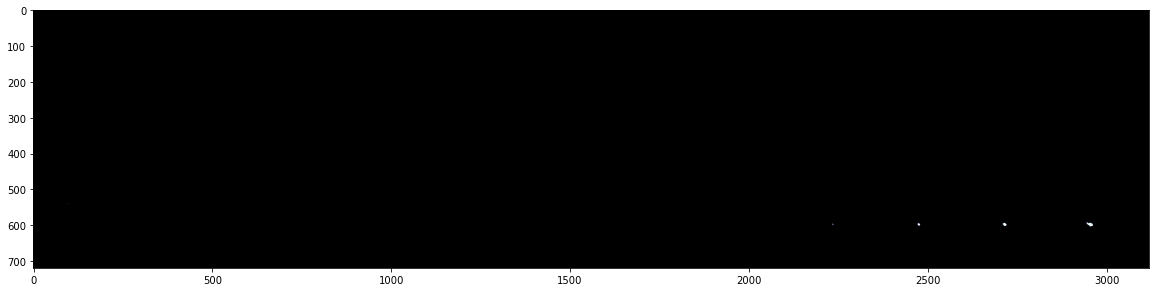

<Figure size 432x288 with 0 Axes>

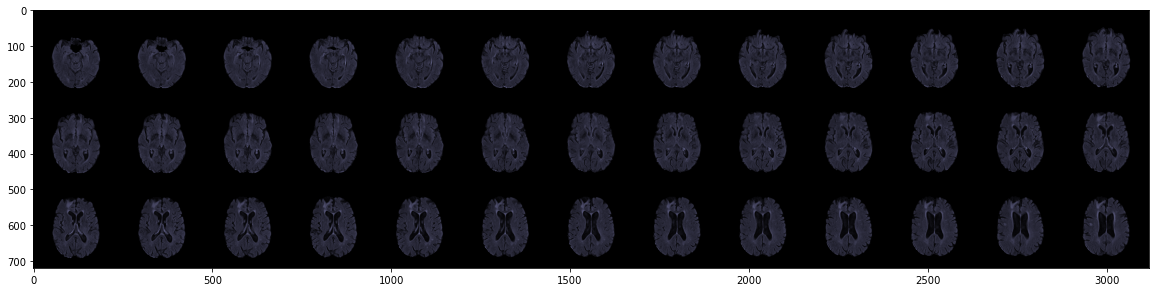

<Figure size 432x288 with 0 Axes>

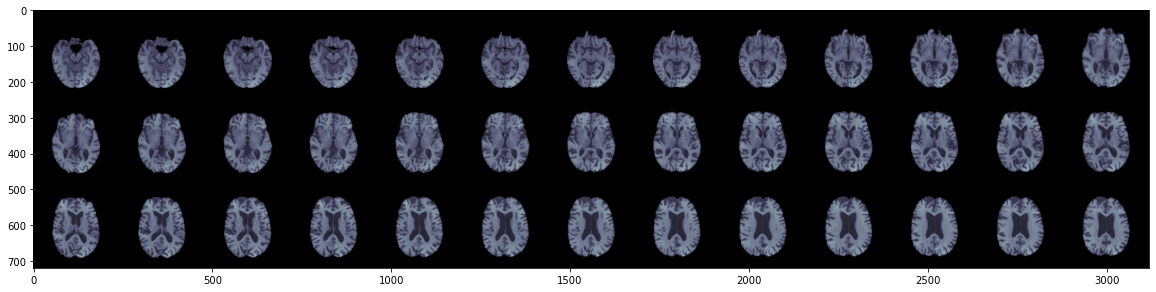

<Figure size 432x288 with 0 Axes>

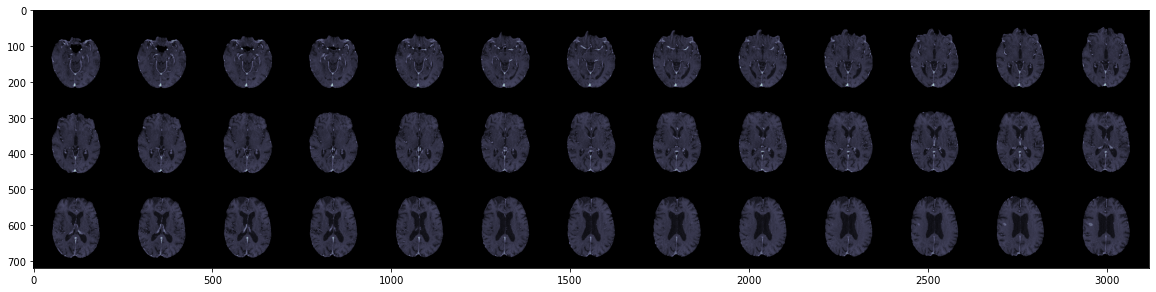

<Figure size 432x288 with 0 Axes>

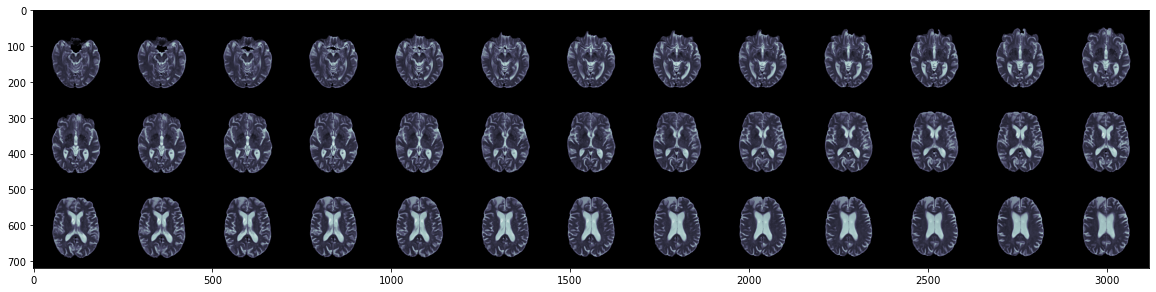

In [3]:
imgs, lbls = data["data"].numpy(), data["target"].numpy()
plt.figure()
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(lbls[0, 0])[960:1680,:], cmap='bone')
plt.show()
plt.figure()
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(imgs[0, 0])[960:1680,:], cmap='bone')
plt.show()
plt.figure()
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(imgs[0, 1])[960:1680,:], cmap='bone')
plt.show()
plt.figure()
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(imgs[0, 2])[960:1680,:], cmap='bone')
plt.show()
plt.figure()
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(imgs[0, 3])[960:1680,:], cmap='bone')
plt.show()

In [4]:
montage(imgs[0, 1]).shape

(3120, 3120)

In [5]:
model = PlainConvUNet(4, 6, (32, 64, 125, 256, 320, 320), nn.Conv3d, 3, (1, 2, 2, 2, 2, 2), (2, 2, 2, 2, 2, 2), 4, (2, 2, 2, 2, 2), False, nn.BatchNorm3d, None, None, None, nn.ReLU, deep_supervision=True)

In [6]:
imgs_test = data["data"][:,:,:128,:128,:128]
lbls_test = data["target"][:,:,:128,:128,:128]
print(imgs_test.shape, lbls_test.shape)
preds_test = model(imgs_test)

torch.Size([3, 4, 128, 128, 128]) torch.Size([3, 1, 128, 128, 128])


In [7]:
print(len(preds_test))
print([preds_test[i].shape for i in range(len(preds_test))])

5
[torch.Size([3, 4, 128, 128, 128]), torch.Size([3, 4, 64, 64, 64]), torch.Size([3, 4, 32, 32, 32]), torch.Size([3, 4, 16, 16, 16]), torch.Size([3, 4, 8, 8, 8])]


In [8]:
lbls_test.unique()

tensor([0., 1., 2., 3.])

In [9]:
from losses import DC_and_CE_loss, MemoryEfficientSoftDiceLoss
soft_dice_kwargs = {
    'batch_dice':True, 
    'smooth': 1e-5, 
    'do_bg': False, 
    'ddp': False
}
ce_kwargs = {}
loss_func = DC_and_CE_loss(soft_dice_kwargs, ce_kwargs, dice_class=MemoryEfficientSoftDiceLoss)

In [10]:
loss = loss_func(preds_test[0], lbls_test)
loss

tensor(1.4088, grad_fn=<AddBackward0>)

In [11]:
from losses import get_tp_fp_fn_tn
output_seg = preds_test[0].argmax(1)[:, None]
preds_onehot_test = torch.zeros(preds_test[0].shape, device=preds_test[0].device, dtype=torch.float32)
preds_onehot_test.scatter_(1, output_seg, 1)
tp, fp, fn, tn = get_tp_fp_fn_tn(preds_onehot_test, lbls_test)
tp, fp, fn, tn

(tensor([[3.1646e+05, 1.0500e+02, 2.0000e+00, 8.8000e+01],
         [2.6484e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [3.0384e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00]]),
 tensor([[1.0120e+03, 5.5235e+05, 4.3313e+05, 7.9401e+05],
         [1.0000e+00, 6.2874e+05, 3.4584e+05, 8.5774e+05],
         [0.0000e+00, 5.5956e+05, 4.1901e+05, 8.1474e+05]]),
 tensor([[1.7774e+06, 3.7800e+02, 0.0000e+00, 2.7670e+03],
         [1.8323e+06, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [1.7933e+06, 0.0000e+00, 0.0000e+00, 0.0000e+00]]),
 tensor([[   2328., 1544321., 1664020., 1300286.],
         [      0., 1468417., 1751310., 1239414.],
         [      0., 1537596., 1678138., 1282414.]]))